# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [48]:
# import os
# script_dir = os.getcwd()
# script_dir

In [49]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. I represent a position as a 2-tuple of the form `(row, col)`. 

In [50]:
%run maze_helper.py
import random

maze = parse_maze(maze_str)

print(maze)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' 'S' ' ' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' 'X' ' ' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X'
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' 'X' ' ' 'X' 'X' 'X' ' ' ' '
  ' ' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']]
Position(0,0): X
Position(8,1): G


<Figure size 432x288 with 0 Axes>

Visualize the maze

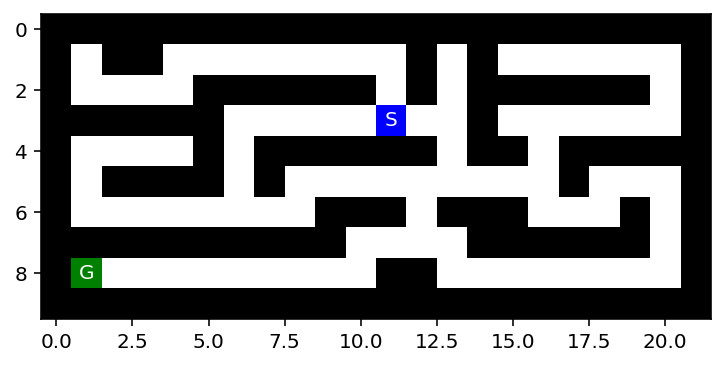

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [52]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

## I have modified this class by adding some functions to meet the needs when working on the search algorithms.

In [53]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def __eq__(self,other):# Here I redefined the object comparison method in order to verify the node if visited
        if self.pos == other.pos: return True
        else : return False
    
    def __bool__(self): # define the bool attribute of the object as True
        return True

    def is_circle(self): # to verify if the node is in a circle
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            if node in path:
                return True
            path.append(node)

        return False

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class.


__Tree and memory management example:__ Create the root node and append the node for going east with a cost of 1.

In [54]:
import sys

# print("Create root node")
# root = Node(pos = (0,0), parent = None, action = None, cost = 0)
# print("root:", root)
# print("root (reference):", repr(root))

# print()
# print("Go east with cost 1 (from the parent root)")
# node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
# print("node2:", node2)
# print("parent of node2: ", node2.parent)
# print("parent of node2 (reference): ", repr(node2.parent))
# # Note: -1 is used because passing root to getrefcount adds one reference
# print("Root is now referenced twice. Reference count for garbage collection (root node):", sys.getrefcount(root)-1)

# print()
# print("Note that the root node is safe from garbage collection as long as we have also a reference in node2") 
# root = None
# print(root)
# print("parent of node2 (reference to root node): ", repr(node2.parent))
# print("Reference count for garbage collection (root node):", sys.getrefcount(node2.parent)-1)

# print()
# print("Path from root to node2")
# path = node2.get_path_from_root()
# print("References:", path)
# print("Positions:", [n.pos for n in path])
# print("Actions:", [n.action for n in path])
# print("Cost:", [n.cost for n in path])

# print()
# node3 = Node(pos=(0,2), parent=node2,action="E",cost=1)
# path = node3.get_path_from_root()
# print("References:", path)
# print("Positions:", [n.pos for n in path])
# print("Actions:", [n.action for n in path])
# print("Cost:", [n.cost for n in path])


# print()
# print("Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage collection.")
# node2 = None



# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth
* Maximum size of the frontier

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

# Your answer goes here
* Initial state: S point in the maze
* Action : four directions such as east, west, north and south
* Transition model : set of actions from location S to location G
* Goal state : reaching the location of G point in the maze
* Path cost: the sum of step costs from S to G


## this function is used for seeking multiple goals

I design these functions since I plan to implement the multiple goals of BFS, DFS and IDS at first

In [55]:
def find_multiple_goal(maze):
    tmp = np.where(maze == 'G')
    result = []
    if len(tmp)>0:
        for i in range(len(tmp[0])):
            result.append((tmp[0][i],tmp[1][i]))
    return result

## this function is used for displaying the multiple goals in the maze

In [56]:
# it could show multiple goal states
def show_maze_v2(maze, fontsize = 10):  
    cmap = colors.ListedColormap(['white', 'black', 'blue', 'green', 'red', 'gray', 'orange'])
    
    # make a deep copy first so the original maze is not changed
    maze = np.copy(maze)
    
    goals = find_multiple_goal(maze)
    start = find_pos(maze, 'S')
    
    # Converts all tile types to integers
    maze[maze == ' '] = 0
    maze[maze == 'X'] = 1 # wall
    maze[maze == 'S'] = 2 # start
    maze[maze == 'G'] = 3 # goal
    maze[maze == 'P'] = 4 # position/final path
    maze[maze == '.'] = 5 # explored squares
    maze[maze == 'F'] = 6 # frontier
    # Converts all string values to integers
    maze = maze.astype(np.int)
    
    fig, ax = plt.subplots()
    ax.imshow(maze, cmap = cmap, norm = colors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N))
    
    plt.text(start[1], start[0], "S", fontsize = fontsize, color = "white",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    for goal in goals:
        plt.text(goal[1], goal[0], "G", fontsize = fontsize, color = "white",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    plt.show()

[(8, 1)]


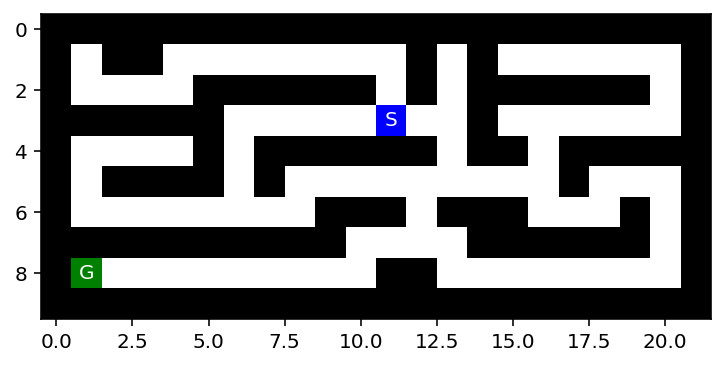

In [57]:
# maze[(3,12)] = 'G'
# find_pos(maze,'S')

a = find_multiple_goal(maze)
print(a)

show_maze_v2(maze)

## This function is used for debugging and displaying the result as talked in the live session.

I find it very useful so that I can watch each step whether it meets the expectation 

In [58]:
# function for debugging 
# it can display G,S,expanded node,path,wall,frontiers
# it's modified based on the function show_maze(which comes from the maze_helper.py)
def show_path(maze, result, fontsize=10):
    cmap = colors.ListedColormap(['white', 'black', 'blue', 'green', 'red', 'gray', 'orange'])
    
    # make a deep copy first so the original maze is not changed
    maze = np.copy(maze)
    
    goals = find_multiple_goal(maze)
    start = find_pos(maze, 'S')
    
    if len(result)>1:
        goal_nodes = result[0]#goal node list
        reached_nodes = result[1]#every node reached yet

        for goal_node in goal_nodes:
            for node in goal_node.get_path_from_root():
                if maze[node.pos] == ' ':
                    maze[node.pos] = 'P'
            
        for reached_node in reached_nodes:
            if maze[reached_node.pos] == ' ':
                maze[reached_node.pos] = '.'

        if len(result)>2:
            frontiers = result[2]
            for frontier in frontiers:
                if maze[frontier.pos] != 'G' and maze[frontier.pos] != 'S':
                    maze[frontier.pos] = 'F'

        if len(result)>3:
            print("Path cost:",result[3][0])
            print("Node expanded:",result[3][1])
            print("Max tree depth:",result[3][2])
            print("Max tree size:",result[3][3])
            print("Max frontier size:",result[3][4])

    # Converts all tile types to integers
    maze[maze == ' '] = 0
    maze[maze == 'X'] = 1 # wall
    maze[maze == 'S'] = 2 # start
    maze[maze == 'G'] = 3 # goal
    maze[maze == 'P'] = 4 # position/final path
    maze[maze == '.'] = 5 # explored squares
    maze[maze == 'F'] = 6 # frontier
    # Converts all string values to integers
    maze = maze.astype(np.int)
    

    fig, ax = plt.subplots()
    ax.imshow(maze, cmap = cmap, norm = colors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N))
    
    plt.text(start[1], start[0], "S", fontsize = fontsize, color = "white",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    for goal in goals:
        plt.text(goal[1], goal[0], "G", fontsize = fontsize, color = "white",
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    plt.show()

## this function is used for verifying if the node is one of the goal state since there are multiple goals.

In [59]:
# to verify if it reaches the goal state
def is_goal(frontier,goal_states):
    if frontier.pos in goal_states: return True
    else: return False

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information during search in the tree, and the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint, you need to implement DFS in a different way without a `reached` data structure and by releasing nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. You will see in your experiments that open spaces are a problem.

In [60]:
# Breadth-first search  supports multiple goals
# maze: the maze
# limit_steps: stop the loop after limite_steps times
# debug: if it's True, it prints every step of walking through the maze
def BFS(maze,limit_steps = 5000,debug=False,actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}):
    frontiers = []
    reached = []
    initial_state = find_pos(maze, what = "S")
    goal_states = find_multiple_goal(maze)
    goal_nodes = []
    # measure variables
    measure_path_cost = 0
    measure_node_expanded = 0
    measure_tree_depth = 0
    measure_max_tree_size = 0
    measure_max_frontier_size = 0

    if actions == "R":
        actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}
        l = list(actions.items())
        random.shuffle(l)
        actions = dict(l)
    
    width,height = maze.shape#width and height of maze
    #build the tree
    root = Node(pos=initial_state,parent=None,action=None,cost=0)
    reached.append(root)
    frontiers.append(root)

    while frontiers :
        if debug: show_path(maze = maze, result=(goal_nodes,reached,frontiers))

        #pop a frontier
        frontier = frontiers.pop(0)

        if len(frontiers)+1 > measure_max_frontier_size: measure_max_frontier_size = len(frontiers)+1 # max frontier size
        if frontier.cost > measure_max_tree_size: measure_max_tree_size = frontier.cost#max tree size

        if is_goal(frontier,goal_states) and (frontier not in goal_nodes):
            goal_nodes.append(frontier)
            if len(goal_nodes) == len(goal_states):
                measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                measure_node_expanded = len(reached) # number of nodes reached
                measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
        else :
            for key,value in actions.items():
                curPos = (frontier.pos[0]+value[0],frontier.pos[1]+value[1])
                if curPos[0] < width and curPos[1] < height and maze[curPos]!="X":
                    subNode = Node(pos=curPos,parent=frontier,action=key,cost=frontier.cost+1)
                    if is_goal(subNode,goal_states) and (subNode not in goal_nodes):
                        goal_nodes.append(subNode)
                        if len(goal_nodes) == len(goal_states):
                            measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                            measure_node_expanded = len(reached) # number of nodes reached
                            measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                            if subNode.cost > measure_max_tree_size : measure_max_tree_size = subNode.cost#max tree size
                            return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
                    else:
                        if subNode not in reached:
                            reached.append(subNode)
                            frontiers.append(subNode)
        limit_steps -= 1
        if limit_steps<=0: break
    #if there is not a solution, it returns empty of goal_nodes
    return ([],reached,[],[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size])


CPU times: user 5.43 ms, sys: 81 µs, total: 5.51 ms
Wall time: 5.47 ms
Path cost: 20
Node expanded: 91
Max tree depth: 19
Max tree size: 19
Max frontier size: 8


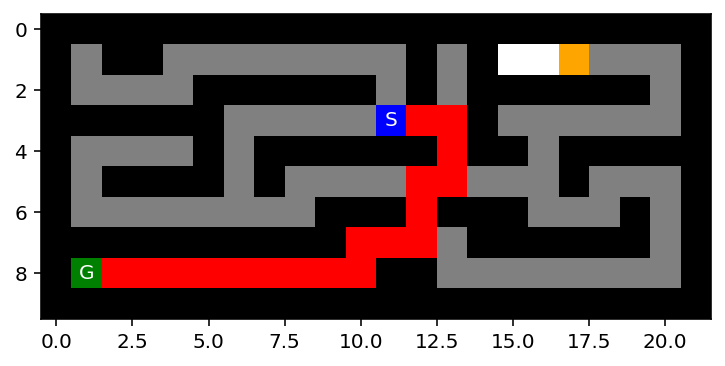

In [61]:
%time result = BFS(maze = maze,actions='R', debug=False)
show_path(maze,result)

In [105]:
# Depth-first search
# maze: the maze
# limit_steps: stop the loop after limite_steps times
# debug: if it's True, it prints every step of walking through the maze
# actions: the order of generating sub node from frontier
def DFS(maze,limit_steps = 5000,debug=False,actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)},depth_limit=50):
    frontiers = []
    reached = []# used for calculating expanded nodes 
    initial_state = find_pos(maze, what = "S")
    goal_states = find_multiple_goal(maze)
    goal_nodes = []
    # measure variables
    measure_path_cost = 0
    measure_node_expanded = 0
    measure_tree_depth = 0
    measure_max_tree_size = 0
    measure_max_frontier_size = 0

    if actions == "R":
        actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}
        l = list(actions.items())
        random.shuffle(l)
        actions = dict(l)
    
    width,height = maze.shape#width and height of maze
    root = Node(pos=initial_state,parent=None,action=None,cost=0)
    reached.append(root)
    frontiers.append(root)

    while frontiers :
        if debug: show_path(maze = maze, result=(goal_nodes,reached,frontiers))
        frontier = frontiers.pop()

        if len(frontiers)+1 > measure_max_frontier_size: measure_max_frontier_size = len(frontiers)+1 # max frontier size
        if frontier.cost > measure_max_tree_size: measure_max_tree_size = frontier.cost#max tree size    

        if is_goal(frontier,goal_states) and (frontier not in goal_nodes):
            goal_nodes.append(frontier)
            if len(goal_nodes) == len(goal_states):
                measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                measure_node_expanded = len(reached) # number of nodes reached
                measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
        else :
            for key,value in actions.items():
                curPos = (frontier.pos[0]+value[0],frontier.pos[1]+value[1])
                if curPos[0] < width and curPos[1] < height and maze[curPos]!="X" and frontier.cost+1<=depth_limit:
                    subNode = Node(pos=curPos,parent=frontier,action=key,cost=frontier.cost+1)
                    if subNode.is_circle() or (subNode in frontiers): 
                        subNode = None
                        continue  
                    else :
                        frontiers.append(subNode)      
                    #this code is only used for calculating the expanded nodes
                    if subNode not in reached: reached.append(subNode)
                            
        limit_steps -= 1
        if limit_steps<=0: break
    #if there is not a solution, it returns False
    return ([],reached,[],[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size])

CPU times: user 19 ms, sys: 1.01 ms, total: 20 ms
Wall time: 19.1 ms
Path cost: 50
Node expanded: 94
Max tree depth: 49
Max tree size: 49
Max frontier size: 5


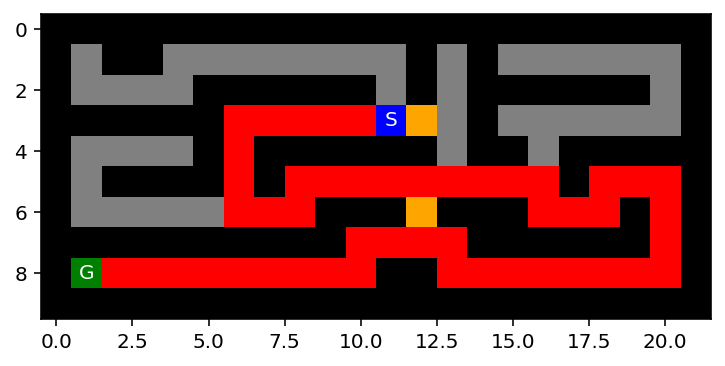

In [115]:
%time result = DFS(maze = maze,actions='R', debug=False,depth_limit=50)
show_path(maze,result)

In [103]:
# Iterative deepening search
# maze: the maze
# limit_steps: stop the loop after limite_steps times
# debug: if it's True, it prints every step of walking through the maze
# actions: the order of generating sub node from frontier
# depth_limit: the maximum depth the tree can reach. If it's set as 0, then it'll gradually increase
def IDS(maze,limit_steps = 5000,debug=False,actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)},depth_limit=50,max_depth_limit=500):
    frontiers = []
    reached = []
    initial_state = find_pos(maze, what = "S")
    goal_states = find_multiple_goal(maze)
    goal_nodes = []
    # measure variables
    measure_path_cost = 0
    measure_node_expanded = 0
    measure_tree_depth = 0
    measure_max_tree_size = 0
    measure_max_frontier_size = 0

    if actions == "R":
        actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}
        l = list(actions.items())
        random.shuffle(l)
        actions = dict(l)
    
    width,height = maze.shape#width and height of maze
    #build the tree
    root = Node(pos=initial_state,parent=None,action=None,cost=0)
    reached.append(root)
    frontiers.append(root)

    if depth_limit == 0 :
        while 1:
            depth_limit += 1
            if depth_limit >= max_depth_limit: break #to avoid dead loop, if the depth limited increases to the max_depth_limit, then it stops increasing.
            frontiers = [root]
            reached = [root]
            while frontiers :
                if debug: show_path(maze = maze, result=(goal_nodes,reached,frontiers))
                frontier = frontiers.pop()
                if len(frontiers)+1 > measure_max_frontier_size: measure_max_frontier_size = len(frontiers)+1 # max frontier size
                if frontier.cost > measure_max_tree_size: measure_max_tree_size = frontier.cost#max tree size
                if is_goal(frontier,goal_states) and (frontier not in goal_nodes):
                    goal_nodes.append(frontier)
                    if len(goal_nodes) == len(goal_states):
                        return goal_nodes,reached,frontiers
                else :
                    for key,value in actions.items():
                        curPos = (frontier.pos[0]+value[0],frontier.pos[1]+value[1])
                        if curPos[0] < width and curPos[1] < height and maze[curPos]!="X":
                            subNode = Node(pos=curPos,parent=frontier,action=key,cost=frontier.cost+1)
                            if is_goal(subNode,goal_states) and (subNode not in goal_nodes):
                                goal_nodes.append(subNode)
                                if len(goal_nodes) == len(goal_states):
                                    return goal_nodes,reached,frontiers
                            else:
                                if subNode not in reached:
                                    reached.append(subNode)
                                    frontiers.append(subNode)
                limit_steps -= 1
                if limit_steps<=0: break        

    else :
        while frontiers :
            if debug: show_path(maze = maze, result=(goal_nodes,reached,frontiers))
            frontier = frontiers.pop()
            if is_goal(frontier,goal_states) and (frontier not in goal_nodes):
                goal_nodes.append(frontier)
                if len(goal_nodes) == len(goal_states):
                    return goal_nodes,reached,frontiers
            else :
                for key,value in actions.items():
                    curPos = (frontier.pos[0]+value[0],frontier.pos[1]+value[1])
                    if curPos[0] < width and curPos[1] < height and maze[curPos]!="X" and frontier.cost+1<=depth_limit:
                        subNode = Node(pos=curPos,parent=frontier,action=key,cost=frontier.cost+1)
                        if subNode.is_circle() or (subNode in frontiers): 
                            subNode = None
                            continue  
                        else :
                            frontiers.append(subNode)      
                        #this code is only used for calculating the expanded nodes
                        if subNode not in reached: reached.append(subNode)
            limit_steps -= 1
            if limit_steps<=0: break
    #if there is not a solution, it returns []
    return ([],reached)

CPU times: user 7.09 ms, sys: 118 µs, total: 7.2 ms
Wall time: 7.13 ms


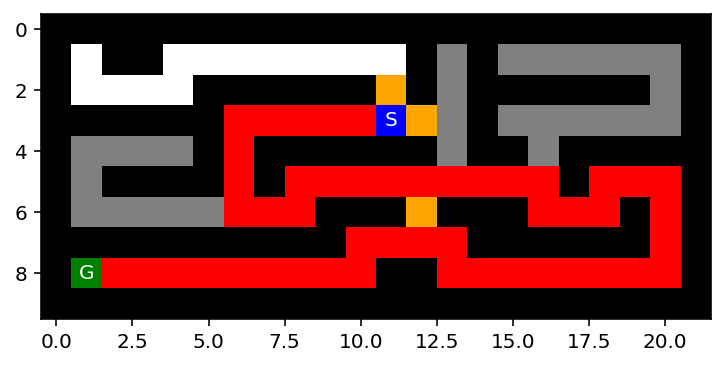

In [104]:
%time result = IDS(maze,depth_limit=0,actions='R')
show_path(maze,result)

How does BFS and DFS deal with loops (cycles)?

In [66]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [67]:
# Discussion

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [68]:
def euclidean(pos1,pos2):
    return np.sqrt(np.sum(np.square(np.subtract(pos1,pos2))))

def manhattan(pos1,pos2):
    return np.sum(np.abs(np.subtract(pos1,pos2)))

# heuristic function
# when the initialPos doesn't set, it only estimates the distance from curPos to targetPos
# when the initialPos sets, it estimates the sum of distances between curPos to targetPos and between curPos to initialPos
def cost_evaluation(curPos,targetPos,initialPos=None,function=manhattan):
    if initialPos == None:
        return function(curPos,targetPos)
    else:
        return function(curPos,targetPos)+function(curPos,initialPos)


print(manhattan((2,2),(3,1)))
print(euclidean((2,2),(3,1)))
print(cost_evaluation(curPos=(2,2),targetPos=(3,1)))


2
1.4142135623730951
2


In [69]:
#Greedy best-first search
# maze: the maze
# limit_steps: stop the loop after limite_steps times
# debug: if it's True, it prints every step of walking through the maze
# actions: the order of generating sub node from frontier
def GBF(maze,limit_steps=5000,debug=False,actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}):
    frontiers = []
    reached = []
    initial_state = find_pos(maze, what = "S")
    goal_state = find_pos(maze, what = 'G')
    goal_states = [goal_state]
    goal_nodes = []
    # measure variables
    measure_path_cost = 0
    measure_node_expanded = 0
    measure_tree_depth = 0
    measure_max_tree_size = 0
    measure_max_frontier_size = 0

    if actions == "R":
        actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}
        l = list(actions.items())
        random.shuffle(l)
        actions = dict(l)
    
    width,height = maze.shape#width and height of maze
    #build the tree
    root = Node(pos=initial_state,parent=None,action=None,cost=0)
    reached.append(root)
    frontiers.append(root)

    while frontiers :
        if debug: show_path(maze = maze, result=(goal_nodes,reached,frontiers))

        if len(frontiers) > 1:
            frontiers.sort(key=lambda x: cost_evaluation(curPos = x.pos,targetPos = goal_state))

        #pop a frontier
        frontier = frontiers.pop(0)

        if len(frontiers)+1 > measure_max_frontier_size: measure_max_frontier_size = len(frontiers)+1 # max frontier size
        if frontier.cost > measure_max_tree_size: measure_max_tree_size = frontier.cost#max tree size

        if is_goal(frontier,goal_states) and (frontier not in goal_nodes):
            goal_nodes.append(frontier)
            if len(goal_nodes) == len(goal_states):
                measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                measure_node_expanded = len(reached) # number of nodes reached
                measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
        else :
            for key,value in actions.items():
                curPos = (frontier.pos[0]+value[0],frontier.pos[1]+value[1])
                if curPos[0] < width and curPos[1] < height and maze[curPos]!="X":
                    subNode = Node(pos=curPos,parent=frontier,action=key,cost=frontier.cost+1)
                    if is_goal(subNode,goal_states) and (subNode not in goal_nodes):
                        goal_nodes.append(subNode)
                        if len(goal_nodes) == len(goal_states):
                            measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                            measure_node_expanded = len(reached) # number of nodes reached
                            measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                            if subNode.cost > measure_max_tree_size : measure_max_tree_size = subNode.cost#max tree size
                            return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
                    else:
                        if subNode not in reached:
                            reached.append(subNode)
                            frontiers.append(subNode)
        limit_steps -= 1
        if limit_steps<=0: break
    #if there is not a solution, it returns empty of goal_nodes
    return ([],reached,[],[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size])

CPU times: user 1.69 ms, sys: 7 µs, total: 1.69 ms
Wall time: 1.7 ms
Path cost: 30
Node expanded: 43
Max tree depth: 29
Max tree size: 29
Max frontier size: 5


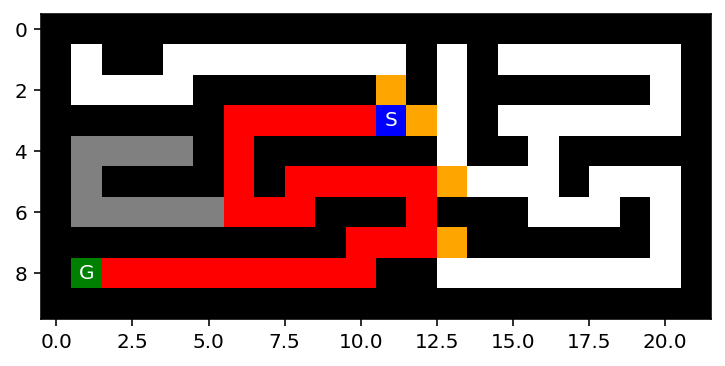

In [70]:
%time result = GBF(maze=maze,debug=False)
show_path(maze,result)

In [88]:
# A* search
# maze: the maze
# limit_steps: stop the loop after limite_steps times
# debug: if it's True, it prints every step of walking through the maze
# actions: the order of generating sub node from frontier
def AStar(maze,limit_steps=5000,debug=False,actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}):
    frontiers = []
    reached = []
    initial_state = find_pos(maze, what = "S")
    goal_state = find_pos(maze, what = 'G')
    goal_states = [goal_state]
    goal_nodes = []
    # measure variables
    measure_path_cost = 0
    measure_node_expanded = 0
    measure_tree_depth = 0
    measure_max_tree_size = 0
    measure_max_frontier_size = 0

    if actions == "R":
        actions = {"N":(-1,0), "S":(1,0), "W":(0,-1), "E":(0,1)}
        l = list(actions.items())
        random.shuffle(l)
        actions = dict(l)
    
    width,height = maze.shape#width and height of maze
    
    root = Node(pos=initial_state,parent=None,action=None,cost=0)
    reached.append(root)
    frontiers.append(root)

    while frontiers :
        if debug: show_path(maze = maze, result=(goal_nodes,reached,frontiers))

        if len(frontiers) > 1:
            frontiers.sort(key=lambda x: cost_evaluation(curPos = x.pos,targetPos = goal_state, initialPos=initial_state))

        #pop a frontier
        frontier = frontiers.pop(0)

        if len(frontiers)+1 > measure_max_frontier_size: measure_max_frontier_size = len(frontiers)+1 # max frontier size

        if frontier.cost > measure_max_tree_size: measure_max_tree_size = frontier.cost#max tree size

        if is_goal(frontier,goal_states) and (frontier not in goal_nodes):
            goal_nodes.append(frontier)
            if len(goal_nodes) == len(goal_states):
                measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                measure_node_expanded = len(reached) # number of nodes reached
                measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
        else :
            for key,value in actions.items():
                curPos = (frontier.pos[0]+value[0],frontier.pos[1]+value[1])
                if curPos[0] < width and curPos[1] < height and maze[curPos]!="X":
                    subNode = Node(pos=curPos,parent=frontier,action=key,cost=frontier.cost+1)
                    if is_goal(subNode,goal_states) and (subNode not in goal_nodes):
                        goal_nodes.append(subNode)
                        if len(goal_nodes) == len(goal_states):
                            measure_path_cost = sum(len(x.get_path_from_root()) for x in goal_nodes)# path cost
                            measure_node_expanded = len(reached) # number of nodes reached
                            measure_tree_depth = max(x.cost for x in goal_nodes) # tree depth reached
                            if subNode.cost > measure_max_tree_size : measure_max_tree_size = subNode.cost#max tree size
                            return goal_nodes,reached,frontiers,[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size]
                    else:
                        if subNode not in reached:
                            reached.append(subNode)
                            frontiers.append(subNode)
        limit_steps -= 1
        if limit_steps<=0: break
    #if there is not a solution, it returns empty of goal_nodes
    return ([],reached,[],[measure_path_cost,measure_node_expanded,measure_tree_depth,measure_max_tree_size,measure_max_frontier_size])
    

CPU times: user 12.1 ms, sys: 573 µs, total: 12.7 ms
Wall time: 12.1 ms
Path cost: 30
Node expanded: 45
Max tree depth: 29
Max tree size: 29
Max frontier size: 5


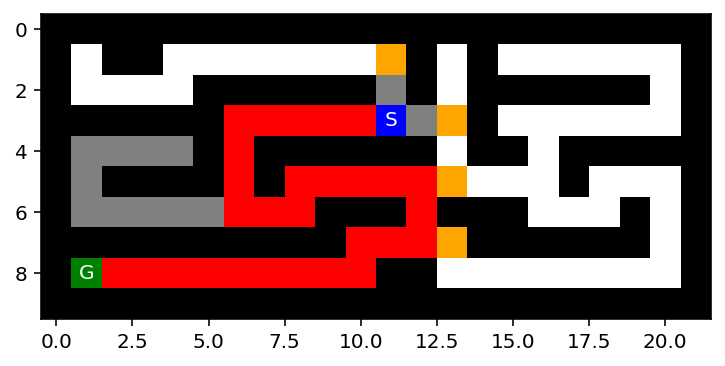

In [89]:
%time result = AStar(maze=maze,debug=False)
show_path(maze,result)

Are your implementations complete and optimal? What is the time and space complexity?

In [73]:
# Discussion

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts. 

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [74]:
# Add code, table, charts.

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | nodes expanded | max tree depth | max tree size | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [75]:
# Add discussion

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

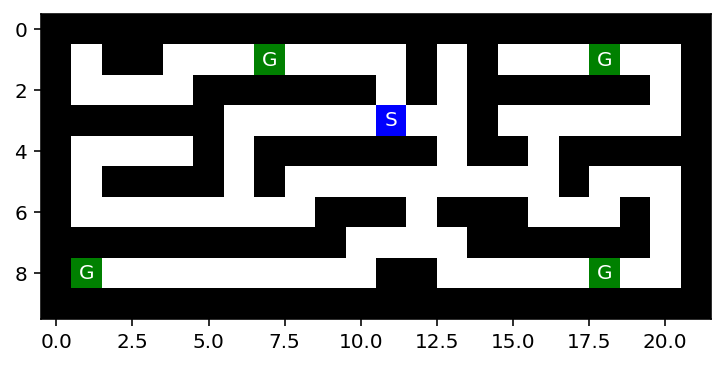

In [76]:
# Your code/answer goes here
f_m = open("small_maze_multiple_goals.txt", "r")
maze_str_m = f_m.read()
maze_m = parse_maze(maze_str_m)

show_maze_v2(maze_m)


CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.97 ms
Path cost: 60
Node expanded: 80
Max tree depth: 19
Max tree size: 19
Max frontier size: 7


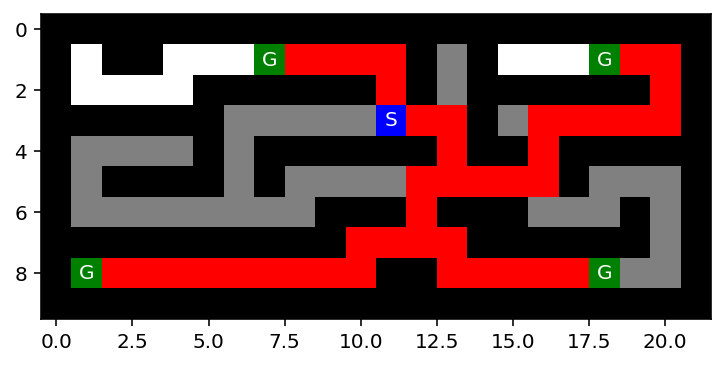

In [77]:
%time result_m = BFS(maze_m)
show_path(maze_m,result_m)

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2.29 ms


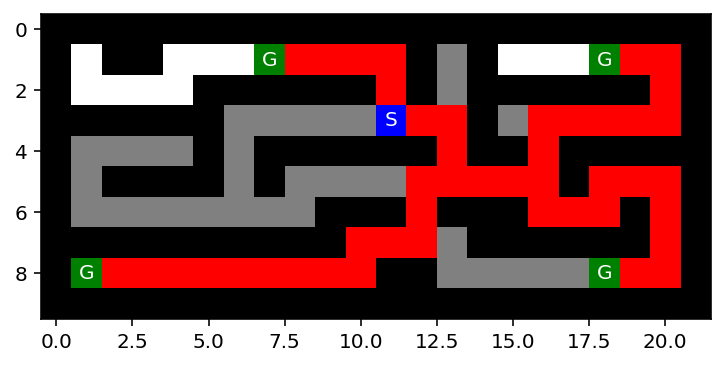

In [78]:
%time result_m = DFS(maze_m)
show_path(maze_m,result_m)

CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 1.99 ms


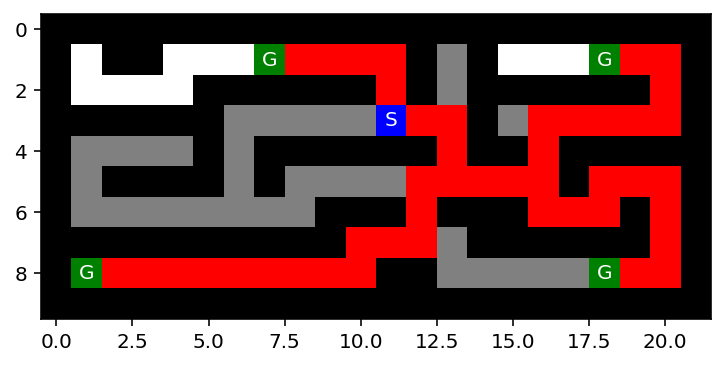

In [79]:
%time result_m = IDS(maze_m)
show_path(maze_m,result_m)

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [80]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [81]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [82]:
# Your code/answer goes here